In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [13]:
def modelFit(alg, dtrain, predictors, target, useTrainCV = True, early_stopping_rounds = 50, cv_folds = 5):
    
    '''.'''
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label = dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,\
                         metrics = 'auc', early_stopping_rounds = early_stopping_rounds, verbose_eval = 100)
        alg.set_params(n_estimators = cvresult.shape[0])
    
    alg.fit(dtrain[predictors], dtrain[target], eval_metric = 'auc')
    
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    print('\nModel Report')
    print('Accuracy : {:.4g}'.format(metrics.accuracy_score(dtrain[target].values, dtrain_predictions)))
    print('AUC Score (Train): {:f}'.format(metrics.roc_auc_score(dtrain[target], dtrain_predprob)))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending = False)
    feat_imp.plot(kind = 'bar', title = 'Feature Importances')
    plt.ylabel('Feature Importance Score')

In [3]:
#Import the data!
train = pd.read_csv('Data/Santander/train.csv')
test = pd.read_csv('Data/Santander/test.csv')

dropCols = []
for i in train.columns.values:
    if len(train[i].unique()) == 1:
        dropCols.append(i)
print('Dropping {} columns due to non-unique entries'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

dropCols = []
c = train.columns
for i in range(len(c)-1):
    v = train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train[c[j]].values):
            dropCols.append(c[j])
print('Dropping {} columns due to duplicate columns'.format(len(dropCols)))
train.drop(dropCols, axis = 1,  inplace = True)
test.drop(dropCols, axis = 1, inplace = True)

train.loc[train.var3 < -10000, 'var3'] = np.nan
test.loc[test.var3 < -10000, 'var3'] = np.nan

colsWithNAN = []
for i in train.columns.values:
    if train[i].isnull().sum() > 0:
        colsWithNAN.append(i)
train.drop(colsWithNAN, axis = 1,  inplace = True)
test.drop(colsWithNAN, axis = 1, inplace = True)

Dropping 34 columns due to non-unique entries
Dropping 29 columns due to duplicate columns


Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.804353+0.0130118070229	cv-train-auc:0.8121966+0.000880157395015
[100]	cv-test-auc:0.8386884+0.00384264932566	cv-train-auc:0.887575+0.000955200502512



Model Report
Accuracy : 0.961
AUC Score (Train): 0.870559


Stopping. Best iteration:
[65] cv-mean:0.838893	cv-std:0.0041722063228


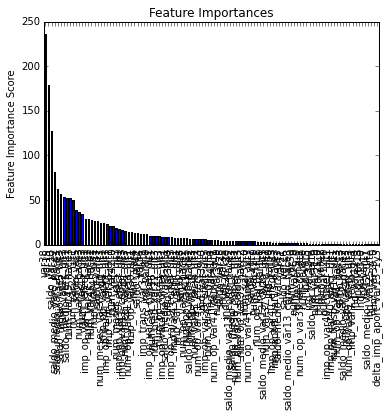

In [14]:
pred = [i for i in train.columns if i not in ['ID', 'TARGET']]
xgb1 = XGBClassifier(learning_rate = 0.1,\
                    n_estimators = 1000,\
                    max_depth = 5,\
                    min_child_weight = 1,\
                    gamma = 0,\
                    subsample = 0.8,\
                    colsample_bytree = 0.8,\
                    objective = 'binary:logistic',\
                    nthread = 8,\
                    scale_pos_weight= 1,\
                    seed = 42)
modelFit(xgb1, train, pred, 'TARGET')

In [15]:
paramTest1 = {'max_depth': range(3,10,2), 'min_child_weight' : range(1,6,2)}

gSearch1 = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.1,\
                                                n_estimators = 65,\
                                                gamma = 0,\
                                                subsample = 0.8,\
                                                colsample_bytree = 0.8,\
                                                objective = 'binary:logistic',\
                                                nthread = 8,\
                                                scale_pos_weight= 1,\
                                                seed = 42),
                       param_grid = paramTest1, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch1.fit(train[pred], train['TARGET'])
gSearch1.grid_scores_, gSearch1.best_params_, gSearch1.best_score_

([mean: 0.83644, std: 0.00845, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83701, std: 0.00865, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83711, std: 0.00923, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.83957, std: 0.00861, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.83980, std: 0.00947, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84026, std: 0.00872, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83884, std: 0.00925, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.84036, std: 0.00896, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83908, std: 0.00988, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83553, std: 0.00991, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83802, std: 0.00949, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83795, std: 0.01021, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 3

In [16]:
paramTest2 = {'max_depth': [6,7,8], 'min_child_weight' : [2,3,4]}

gSearch2 = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.1,\
                                                n_estimators = 65,\
                                                gamma = 0,\
                                                subsample = 0.8,\
                                                colsample_bytree = 0.8,\
                                                objective = 'binary:logistic',\
                                                nthread = 8,\
                                                scale_pos_weight= 1,\
                                                seed = 42),
                       param_grid = paramTest2, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch2.fit(train[pred], train['TARGET'])
gSearch2.grid_scores_, gSearch2.best_params_, gSearch2.best_score_

([mean: 0.83899, std: 0.00914, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: 0.83987, std: 0.00962, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.84024, std: 0.00953, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83775, std: 0.00882, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.84036, std: 0.00896, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83939, std: 0.00948, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: 0.83727, std: 0.00862, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: 0.83900, std: 0.00934, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: 0.83880, std: 0.01089, params: {'max_depth': 8, 'min_child_weight': 4}],
 {'max_depth': 7, 'min_child_weight': 3},
 0.8403581939962137)

In [18]:
paramTest3 = {'gamma': [i/10.0 for i in range(0,5)]}

gSearch3 = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.1,\
                                                n_estimators = 65,\
                                                max_depth = 7,\
                                                min_child_weight = 3,\
                                                subsample = 0.8,\
                                                colsample_bytree = 0.8,\
                                                objective = 'binary:logistic',\
                                                nthread = 8,\
                                                scale_pos_weight= 1,\
                                                seed = 42),
                       param_grid = paramTest3, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch3.fit(train[pred], train['TARGET'])
gSearch3.grid_scores_, gSearch3.best_params_, gSearch3.best_score_

([mean: 0.84036, std: 0.00896, params: {'gamma': 0.0},
  mean: 0.83918, std: 0.00957, params: {'gamma': 0.1},
  mean: 0.83881, std: 0.00946, params: {'gamma': 0.2},
  mean: 0.83982, std: 0.00943, params: {'gamma': 0.3},
  mean: 0.83930, std: 0.00992, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8403581939962137)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.8066938+0.0108747361237	cv-train-auc:0.8157388+0.00199360852727
[100]	cv-test-auc:0.8373086+0.00461186585234	cv-train-auc:0.9080352+0.00112567906616



Model Report
Accuracy : 0.9612
AUC Score (Train): 0.888794


Stopping. Best iteration:
[57] cv-mean:0.8391516	cv-std:0.00411646768966


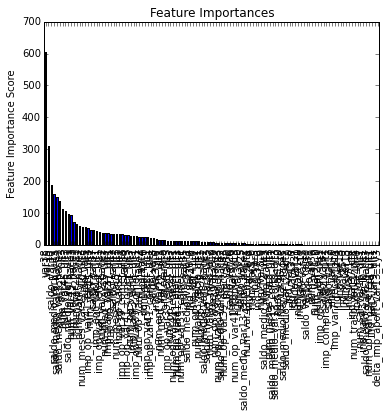

In [19]:
xgb2 = XGBClassifier(learning_rate = 0.1,\
                    n_estimators = 1000,\
                    max_depth = 7,\
                    min_child_weight = 3,\
                    gamma = 0,\
                    subsample = 0.8,\
                    colsample_bytree = 0.8,\
                    objective = 'binary:logistic',\
                    nthread = 8,\
                    scale_pos_weight= 1,\
                    seed = 42)
modelFit(xgb2, train, pred, 'TARGET')

In [20]:
paramTest4 = {'subsample': [i/10.0 for i in range(6,11)], 'colsample_bytree' : [i/10.0 for i in range(6,11)]}

gSearch4 = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.1,\
                                                n_estimators = 57,\
                                                max_depth = 7,\
                                                min_child_weight = 3,\
                                                gamma = 0,\
                                                objective = 'binary:logistic',\
                                                nthread = 8,\
                                                scale_pos_weight= 1,\
                                                seed = 42),
                       param_grid = paramTest4, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch4.fit(train[pred], train['TARGET'])
gSearch4.grid_scores_, gSearch4.best_params_, gSearch4.best_score_

([mean: 0.83906, std: 0.00963, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.83844, std: 0.01051, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.83893, std: 0.01007, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.83874, std: 0.01074, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.83921, std: 0.00946, params: {'subsample': 1.0, 'colsample_bytree': 0.6},
  mean: 0.84046, std: 0.00901, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.83841, std: 0.00999, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.83843, std: 0.00955, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.83816, std: 0.01010, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.83881, std: 0.00922, params: {'subsample': 1.0, 'colsample_bytree': 0.7},
  mean: 0.83936, std: 0.00852, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.83859, std: 0.00987, params: {'subsample': 0.7, 'colsample_bytree'

In [23]:
paramTest4b = {'subsample': [i/100.0 for i in range(75,90,5)], 'colsample_bytree' : [i/100.0 for i in range(75,90,5)]}

gSearch4b = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.1,\
                                                n_estimators = 57,\
                                                max_depth = 7,\
                                                min_child_weight = 3,\
                                                gamma = 0,\
                                                objective = 'binary:logistic',\
                                                nthread = 8,\
                                                scale_pos_weight= 1,\
                                                seed = 42),
                       param_grid = paramTest4b, scoring = 'roc_auc', n_jobs = 8, iid = False, cv = 5)
gSearch4b.fit(train[pred], train['TARGET'])
gSearch4b.grid_scores_, gSearch4b.best_params_, gSearch4b.best_score_

([mean: 0.83857, std: 0.00995, params: {'subsample': 0.75, 'colsample_bytree': 0.75},
  mean: 0.83933, std: 0.01024, params: {'subsample': 0.8, 'colsample_bytree': 0.75},
  mean: 0.83802, std: 0.01029, params: {'subsample': 0.85, 'colsample_bytree': 0.75},
  mean: 0.83935, std: 0.00964, params: {'subsample': 0.75, 'colsample_bytree': 0.8},
  mean: 0.84049, std: 0.00947, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.83901, std: 0.00969, params: {'subsample': 0.85, 'colsample_bytree': 0.8},
  mean: 0.83866, std: 0.00950, params: {'subsample': 0.75, 'colsample_bytree': 0.85},
  mean: 0.83904, std: 0.00977, params: {'subsample': 0.8, 'colsample_bytree': 0.85},
  mean: 0.83924, std: 0.00901, params: {'subsample': 0.85, 'colsample_bytree': 0.85}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.84049231084975773)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-auc:0.8066938+0.0108747361237	cv-train-auc:0.8157388+0.00199360852727
[100]	cv-test-auc:0.8318892+0.00620236053128	cv-train-auc:0.8575532+0.00137759143435
[200]	cv-test-auc:0.8360562+0.005929980688	cv-train-auc:0.8690326+0.000878605622563
[300]	cv-test-auc:0.8383238+0.0054753970961	cv-train-auc:0.8781668+0.000403659955903
[400]	cv-test-auc:0.839358+0.00508138717281	cv-train-auc:0.8862802+0.000618697147238
[500]	cv-test-auc:0.8399604+0.00523075927949	cv-train-auc:0.8923786+0.000834358819693
[600]	cv-test-auc:0.840183+0.00509937498131	cv-train-auc:0.896565+0.00103124332725



Model Report
Accuracy : 0.9612
AUC Score (Train): 0.891269


Stopping. Best iteration:
[582] cv-mean:0.8402326	cv-std:0.00512397574545


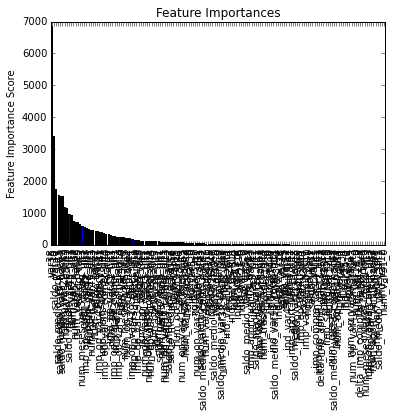

In [27]:
xgb3 = XGBClassifier(learning_rate = 0.01,\
                     n_estimators = 5000,\
                     max_depth = 7,\
                     min_child_weight = 3,\
                     gamma = 0,\
                     subsample = 0.8,\
                     colsample_bytree = 0.8,\
                     objective = 'binary:logistic',\
                     nthread = 8,\
                     scale_pos_weight= 1,\
                     seed = 42)
modelFit(xgb3, train, pred, 'TARGET')

In [28]:
xgbfinal = XGBClassifier(learning_rate = 0.01,\
                     n_estimators = 582,\
                     max_depth = 7,\
                     min_child_weight = 3,\
                     gamma = 0,\
                     subsample = 0.8,\
                     colsample_bytree = 0.8,\
                     objective = 'binary:logistic',\
                     nthread = 8,\
                     scale_pos_weight= 1,\
                     seed = 42)
xgbfinal.fit(train[pred], train['TARGET'], eval_metric = 'auc')

submission = pd.DataFrame({'ID' : test.ID, 'TARGET' : xgbfinal.predict_proba(test[pred])[:,1]})
submission.to_csv('submission3.csv', index = False)

In [35]:
#trainRed = SelectKBest(f_classif, k=150).fit_transform(train[pred], train['TARGET'])
#pred2 = [i for i in trainRed.columns if i not in ['ID']]
#modelFit(xgbfinal, trainRed, pred2, 'TARGET')

AttributeError: 'numpy.ndarray' object has no attribute 'columns'